<div align="center">
    <img src='../images/hw4.png' alt='hw4-log'/>
</div>

## Import Libraries

In [214]:
# Scientific
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer

import warnings
warnings.filterwarnings('ignore')

## Download Dataset

In [8]:
!wget -P ../dataset/ https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-11 16:36:29--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘../dataset/data.csv’

data.csv            100%[===================>]   1.41M   274KB/s    in 5.3s    

2023-10-11 16:36:35 (274 KB/s) - ‘../dataset/data.csv’ saved [1475504/1475504]



## Load Dataset

In [179]:
data = pd.read_csv('../dataset/data.csv')

In [180]:
data.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## Feature Selection

In [181]:
columns = ['Make', 'Model', 'Year','Engine HP','Engine Cylinders',
           'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']

In [182]:
filterd_data = data[columns].copy()

## Data Prepration

In [183]:
filterd_data.columns = filterd_data.columns.str.replace(' ', '_').str.lower()

In [184]:
filterd_data.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [185]:
filterd_data.fillna(0, inplace=True)

In [186]:
filterd_data.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [187]:
filterd_data.rename(columns = {'msrp':'price'}, inplace=True)

In [188]:
filterd_data['above_average'] = filterd_data.price.apply(lambda x: 1 if x > filterd_data.price.mean() else 0 )

In [189]:
X = filterd_data[filterd_data.columns[:-1]]
y = filterd_data[filterd_data.columns[-1]]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=1,
                                                    test_size=0.20)

In [191]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    stratify=y_train,
                                                    random_state=1,
                                                    test_size=0.20)

In [192]:
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'transmission_type', 'vehicle_style']

## Question 1: ROC AUC feature importance

In [193]:
best = float('-inf')
for num_column in numerical:
    auc_score = roc_auc_score(filterd_data['above_average'], filterd_data[num_column])
    print(f'column:{num_column} ----> auc:{round(auc_score, 2)}')
    
    if auc_score > best:
        best = auc_score
        best_feature = num_column
print(f'\nbest feature: {best_feature} ---> score: {round(best, 2)}')

column:year ----> auc:0.69
column:engine_hp ----> auc:0.92
column:engine_cylinders ----> auc:0.77
column:highway_mpg ----> auc:0.37
column:city_mpg ----> auc:0.33

best feature: engine_hp ---> score: 0.92


## Question 2: Training the model
 - Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

### One Hot

In [194]:
dv = DictVectorizer(sparse=False)

train_dict = X_train[categorical + numerical].to_dict(orient='records')
X_train1 = dv.fit_transform(train_dict)

val_dict = X_val[categorical + numerical].to_dict(orient='records')
X_val1 = dv.transform(val_dict)

### Train model

In [195]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
_ = model.fit(X_train1, y_train)

In [196]:
y_pred = model.predict_proba(X_val1)[:, 1]

In [197]:
auc_score = roc_auc_score(y_val, y_pred)
print(f"AUC: {round(auc_score, 3)}")

AUC: 0.975


## Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them

In [206]:
thresholds = np.linspace(0, 1, 100)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
scores = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

In [207]:
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn', 'precision', 'recall']
data_scores = pd.DataFrame(scores, columns=columns)

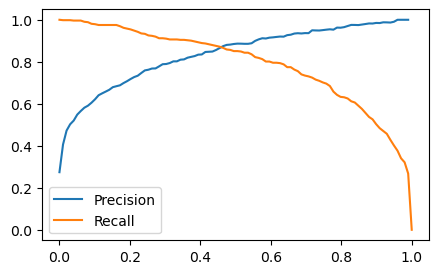

In [208]:
plt.figure(figsize=((5,3)))
plt.plot(data_scores['thresholds'], data_scores['precision'], label='Precision')
plt.plot(data_scores['thresholds'], data_scores['recall'], label='Recall')
plt.legend()
plt.show()

## Question 4: F1 score

In [209]:
thresholds = np.linspace(0, 1, 10)
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
scores = []
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    f1 = 2 * precision * recall / (precision + recall)
    
    scores.append((t, tp, fp, fn, tn, precision, recall, f1))

In [210]:
columns = ['thresholds', 'tp', 'tn', 'fp', 'fn', 'precision', 'recall', 'f1']
df_score1 = pd.DataFrame(scores, columns=columns)

In [211]:
df_score1

,thresholds,tp,tn,fp,fn,precision,recall,f1
0,0.000000,523,1384,0,0,0.274253,1.000000,0.430453
1,0.111111,510,286,13,1098,0.640704,0.975143,0.773313
2,0.222222,493,179,30,1205,0.733631,0.942639,0.825105
3,0.333333,474,117,49,1267,0.802030,0.906310,0.850987
4,0.444444,458,77,65,1307,0.856075,0.875717,0.865784
5,0.555556,430,48,93,1336,0.899582,0.822180,0.859141
6,0.666667,399,28,124,1356,0.934426,0.762906,0.840000
7,0.777778,344,17,179,1367,0.952909,0.657744,0.778281
8,0.888889,275,5,248,1379,0.982143,0.525813,0.684932
9,1.000000,0,0,523,1384,NaN,0.000000,NaN


In [212]:
df_score1['f1'].max()

0.8657844990548204

In [205]:
df_score1[df_score1['f1'] == df_score1['f1'].max()]

,thresholds,tp,tn,fp,fn,precision,recall,f1
47,0.47,452,64,71,1320,0.875969,0.864245,0.870067


## Question 5: 5-Fold CV